In [10]:

import h5py
import matplotlib.pyplot as plt
import numpy as np
import numpy.ma as ma
import os
from qutip import*
import matplotlib as mpl
from matplotlib import cm
from matplotlib.colors import LinearSegmentedColormap as lsc
import time
from matplotlib.pyplot import figure, show
from matplotlib import gridspec
from tqdm.auto import tqdm # progress bar
from scipy.optimize import curve_fit
from tcsim.system import*
from tcsim.visualization import*

In [11]:
import numpy as np
import cvxpy as cp
import qutip as qt
from scipy.special import genlaguerre
from math import sqrt, factorial
import matplotlib.pyplot as plt
from scipy.linalg import lstsq, eigh, svd
from scipy.sparse.linalg import LinearOperator, lsqr
import h5py
from tqdm.auto import tqdm # progress bar
from matplotlib import colors
from tcsim.visualization import*
from tcsim.gates import*
from tcsim.system import*
from tcsim.analyze.dataloader import*
from tcsim.analyze.fit_funcs.char_func_fringe import char_func_fringe

def vectorize(rho):
    """
    Turn hermitian matrix rho into a real vector
    vectorize(rho)[:d] = diag(rho)
    vectorize(rho)[d:d + d*(d-1)/2] = Re[upper_triangle(rho)]
    vectorize(rho)[d + d*(d-1)/2:]  = Im[upper_triangle(rho)]
    """
    d = rho.shape[0]  ## the shape of first column - dimension of matrix, e.g. 3x3 matrix d = 3
    n_offd = d*(d-1)//2 
    ret = np.zeros(d**2) #array of zeros with dimensionality d**2
    i = 0
    for m in range(d):
        ret[m] = rho[m, m].real #mth entry in ret is real part of (m,m) diagonal entry of matrix, capped at d
        for n in range(m+1, d):
            ret[d+i] = rho[m, n].real  #set d+ith entry in ret to real part of (m,n) off diagonal entry of matrix
            ret[d+n_offd+i] = rho[m, n].imag
            i += 1
    return ret


def matricize(rvec):
    """
    Invert the vectorize operation such that matricize(vectorize(rho)) == rho
    """
    d = int(np.sqrt(len(rvec)))
    n_offd = d*(d-1)//2
    ret = np.diag(rvec[:d]).astype(np.complex) # 将rvec[:d]转化为一个对角矩阵，并且用a+jb的形式表示
    i = 0
    for m in range(d):
        for n in range(m+1, d):
            real = rvec[d+i]
            imag = rvec[d+n_offd+i]
            val = real + 1j*imag
            ret[m, n] = val
            ret[n, m] = val.conj()
            i += 1
            
def char_ops(hilbert_size, betas):
    ops_list = []

    for beta in tqdm(betas):
        D = displace(100, beta) # need the larger Hilbert space to not get erroneous operators for large beta
        op = D
        op = Qobj(op[:hilbert_size, :hilbert_size]) # truncate to wanted Hilbert space size
        ops_list.append(op)

    return ops_list

def reconstruct_char_complex_convex(char, disps, dim):
    # construct vectors
    basis_vectors = []
    for i in range(dim):
        vector = fock(dim, i)
        basis_vectors.append(vector.full())

    # construct operators
    basis_dms = []
    for vector1 in basis_vectors:
        for vector2 in basis_vectors:
            dm = np.outer(vector2, vector1)
            basis_dms.append(dm)
    Pis = char_ops(dim, disps)
    A = np.zeros((len(Pis), dim*dim), dtype=complex)
    
    for index, a in tqdm(np.ndenumerate(A)):
        A[index] = np.trace(Pis[index[0]].full() @ basis_dms[index[1]])
    
    X = cp.Variable((dim,dim), hermitian=True)
    cost = cp.norm(A @ cp.reshape(X, (dim*dim)) - char, 2)
    constraints = [cp.trace(X) == 1, X >> 0]
    prob = cp.Problem(cp.Minimize(cost), constraints)
    prob.solve()
    reconstructed_rho = Qobj(X.value)
    return reconstructed_rho

def make_disps(xmax, N):
    xs = np.linspace(-xmax, xmax, N)
    X, Y = np.meshgrid(xs, xs)
    return (X + Y*1j).flatten()

In [12]:
def gauss_1(x, amp1, cen1, sigma1):
    return amp1 * (np.exp((-1.0 / 2.0) * (((x - cen1) / sigma1) ** 2)))


def gauss_3(x, amp1, cen1, sigma1, amp2, cen2, sigma2, amp3, cen3, sigma3):
    """ Fitting Function"""
    return amp1 * (np.exp((-1.0 / 2.0) * (((x - cen1) / sigma1) ** 2))) + \
           amp2 * (np.exp((-1.0 / 2.0) * (((x - cen2) / sigma2) ** 2))) + \
           amp3 * (np.exp((-1.0 / 2.0) * (((x - cen3) / sigma3) ** 2)))
           
def extract_amps(xvec, data, p0, bounds, plot = False):
    popt, pcov = curve_fit(gauss_3, xvec,data, p0=p0, bounds=bounds)
    blob_amp = (popt[0]+popt[6])/2
    center_amp = popt[3]

    
    if plot:
        fig, axs = plt.subplots()
        axs.plot(xvec,data, 'b', label="given curve")
        axs.plot(xvec, gauss_3(xvec, *popt), ls=':', label="Fit function", linewidth=4, color='purple')
        for j, (a, c, s )in enumerate( popt.reshape(-1, 3)):
            axs.plot(xvec, gauss_1(xvec, a, c, s), ls='-', label=f"gauss {j+1}", linewidth=1, color='crimson')
        axs.legend()
        axs.autoscale(axis='x', tight=True)
    return blob_amp, center_amp
    


def load_data_single(d, filename, thresh, thresh_fac1 = 1, thresh_fac2 = 1, plot = True):
    
    files = [f for f in os.listdir(d) if f.endswith(filename)]
    #print(files)
    dg = []
    de = []

        #files = files[-5:-1]

    for kk in range(len(files)):
        fname = d + files[kk]
        df = h5py.File(fname, "r")
        data = df["data"]
        data_i = data["I"][:]
        x = data["x"][:, 0][:, 0]
        y = data["y"][0, :][:, 0] 
        n_points_x = len(x)  # sweep points x
        n_points_y = len(y)  # sweep points y
        thresh = thresh
        #ss_data = np.where(data_i < thresh, 1, 0)
        m0 = np.where(data_i[:, 0::3] < thresh*thresh_fac1, 1, 0)
        m1 = np.where(data_i[:, 1::3] < thresh*thresh_fac2, 1, 0)
        m2 = np.where(data_i[:, 2::3] < thresh, 1, 0)
        m1_g = ma.masked_array(m1, mask=m0)
        m2_g = ma.masked_array(m2, mask=m0)

        ## only care about last two measurements
        proj_g = ma.masked_array(m2, mask=m1).mean(axis=0).reshape(n_points_x, n_points_y) * 2 - 1
        proj_e = ma.masked_array(m2, mask=np.logical_not(m1)).mean(axis=0).reshape(n_points_x, n_points_y) * 2 - 1

        ## condition on the first measurement as well
        double_ps_g = ma.masked_array(m2_g, mask=m1_g).mean(axis=0).reshape(n_points_x, n_points_y) * 2 - 1
        double_ps_e = ma.masked_array(m2_g, mask=np.logical_not(m1_g)).mean(axis=0).reshape(n_points_x, n_points_y) * 2 - 1

        dg.append(double_ps_g)
        de.append(double_ps_e)

        
    dg = np.array(dg)
    de = np.array(de)


    proj_g = dg.mean(axis=0)
    proj_e = de.mean(axis=0)
    proj_ge = [proj_g, proj_e]  # m2.mean(axis = 0).reshape(n_points, n_points)

    if plot:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 20))
        f1 = ax1.pcolormesh(y, x, proj_g, cmap="seismic", vmax=1, vmin=-1)
        f2 = ax2.pcolormesh(y, x, proj_e, cmap="seismic", vmax=1, vmin=-1)
        ax1.set_aspect("equal")
        ax1.set_xlabel(r"real($\beta$)")
        ax1.set_ylabel(r"imag($\beta$)")
        ax1.set_title('proj_g')
        ax2.set_aspect("equal")
        ax2.set_xlabel(r"real($\beta$)")
        ax2.set_title('proj_e')
        # fig.colorbar(f2)
    return proj_g, x, y


def odd_cat(N,alpha):
    cat = (coherent(N,alpha) - coherent(N, -alpha)).unit()
    return cat


def reconstruct_dm(data,x, N):
    
    im = np.zeros((data.shape))
    data_with_im = data + 1j*im
    re_rho = reconstruct_char_complex_convex((data_with_im).flatten(),make_disps(np.max(x)*3,len(x)), N)
    rho = Qobj(re_rho)
    return rho


def line(x, m, y):
    return x*m+y


def find_angle(data, x, initial_guess =[0.8,  0.8, 1, 1, np.pi/2, 0], plot = False ):
    ### extract angle of cat
    scaling = 3
    xvec = x*scaling # i define it like this in case i want to slice x
    X, Y = np.meshgrid(xvec, xvec)

        
    popt, pcov = curve_fit(char_func_fringe, (X, Y), data.flatten(), p0=initial_guess, maxfev = 5000)
    angle = popt[4]

    if plot:
        data_fitted1 = char_func_fringe((X, Y), *popt)
        fig, ax = plt.subplots()
        ax.pcolormesh(X,Y, data, cmap="seismic", vmin = -1 , vmax = 1)
        ax.contour(yvec,xvec, data_fitted1.reshape(X.shape))
        ax.set_aspect("equal")
    return angle


# Normal cats

[ 4.52391742e+02 -8.80449303e-02]
0.00019462099330314037


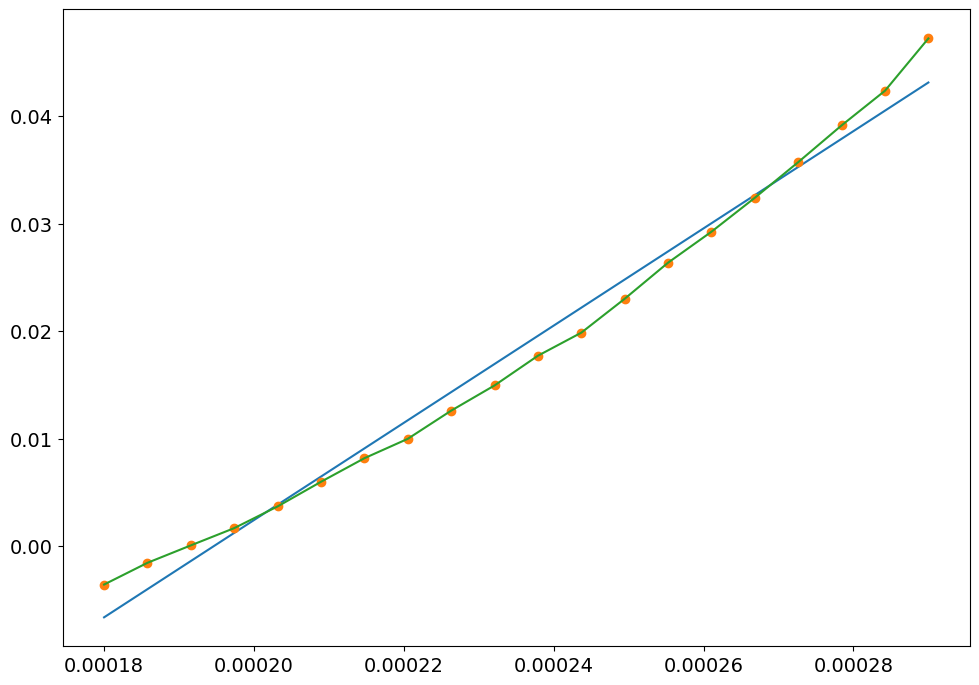

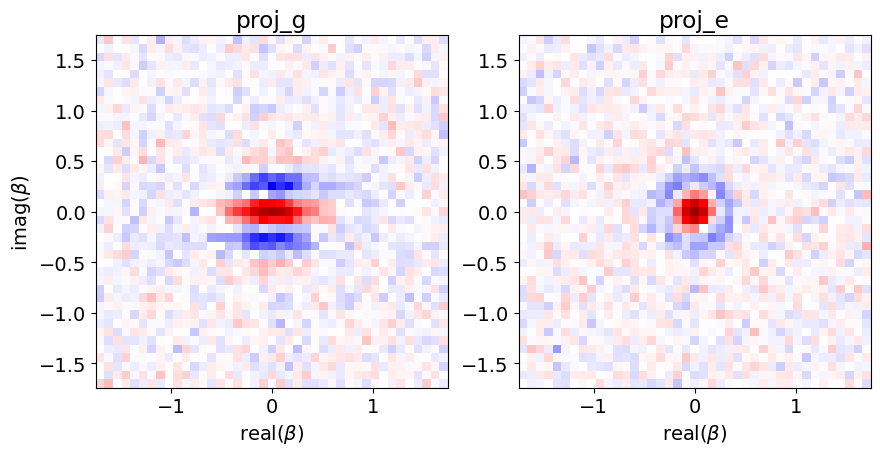

In [23]:
vac_norm = 0.883
filename = 'panther_normal_cat_decay_loop.h5' 

d = ["C:/Users/jonat/Desktop/Coding/tcsim/data_analysis/data/all_data_new/fig4/normal_1/", "C:/Users/jonat/Desktop/Coding/tcsim/data_analysis/data/all_data_new/fig4/normal_20/", "C:/Users/jonat/Desktop/Coding/tcsim/data_analysis/data/all_data_new/fig4/normal_50/", "C:/Users/jonat/Desktop/Coding/tcsim/data_analysis/data/all_data_new/fig4/normal_100/"]

thresholds = np.linspace(1.8e-4,2.9e-4, 20)
floor_values = []
for threshold in thresholds:
    proj_g, x, y= load_data_single(d[3], filename ,thresh=threshold, plot=False)
    floor_values.append(proj_g[0:5,:].mean())
    

popt, pcov = curve_fit(line, thresholds, floor_values, p0= [0,0])
print(popt)
plt.plot(thresholds,line(np.array(thresholds),*popt))
plt.plot(thresholds,floor_values, 'o')
thresh = (-popt[1]/popt[0])
print(thresh)
    
plt.plot(thresholds,floor_values)

proj_g, x,y = load_data_single(d[3], filename, thresh, 1.2, 1)
proj_g_norm = proj_g/0.884

In [95]:
rho = reconstruct_dm(proj_g_norm, x, N)
# find angle 
angle = find_angle(proj_g_norm,x)
# check different alpha values and print overlap with all of them.




alphas = np.linspace(1.6,1.9,10)
for alpha in alphas:
    cat = odd_cat(18, alpha*np.exp(-1j*(angle+np.pi/2)))
    overlap = expect(rho, cat)
    print(np.round(alpha,2), overlap)
    
    

100%|██████████| 1681/1681 [00:16<00:00, 104.69it/s]
544644it [00:08, 63859.18it/s]


1.6 0.4006976270304924
1.63 0.4025882489475101
1.67 0.40376620998896057
1.7 0.4042165396921838
1.73 0.40392924932228547
1.77 0.4028993254036068
1.8 0.40112667125459467
1.83 0.3986160026871853
1.87 0.39537670395364954
1.9 0.39142264967162904


In [17]:
proj_g_norm

array([[-0.03692796, -0.0396707 , -0.00445933, ..., -0.02746575,
        -0.10127922,  0.08752128],
       [ 0.0391267 ,  0.00228866, -0.02174191, ..., -0.02068711,
         0.04512971, -0.00958224],
       [ 0.00845003,  0.01192221,  0.00725524, ..., -0.00650469,
         0.05239603, -0.03298715],
       ...,
       [ 0.07442858,  0.028119  ,  0.0970236 , ..., -0.01970639,
         0.12671066,  0.07046662],
       [-0.07809258,  0.11153418, -0.08439679, ..., -0.00953049,
        -0.01078445, -0.0014904 ],
       [-0.04259529, -0.01684876, -0.03058517, ...,  0.02708644,
         0.00301164,  0.05743344]])

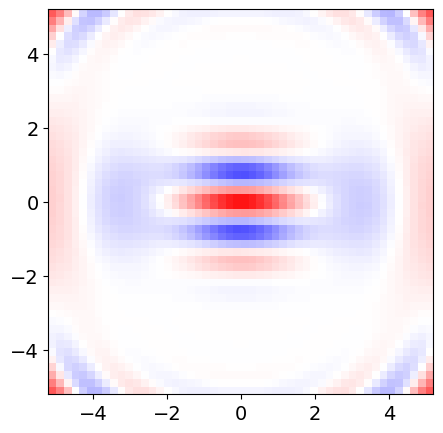

In [82]:
plot_char(tensor(fock(2,0)*fock(2,0).dag(),cat_loss), max_alpha = 5.1)

# Squeezed Cats with 7

[ 3.37738418e+02 -6.96624820e-02]
0.00020626164623291737


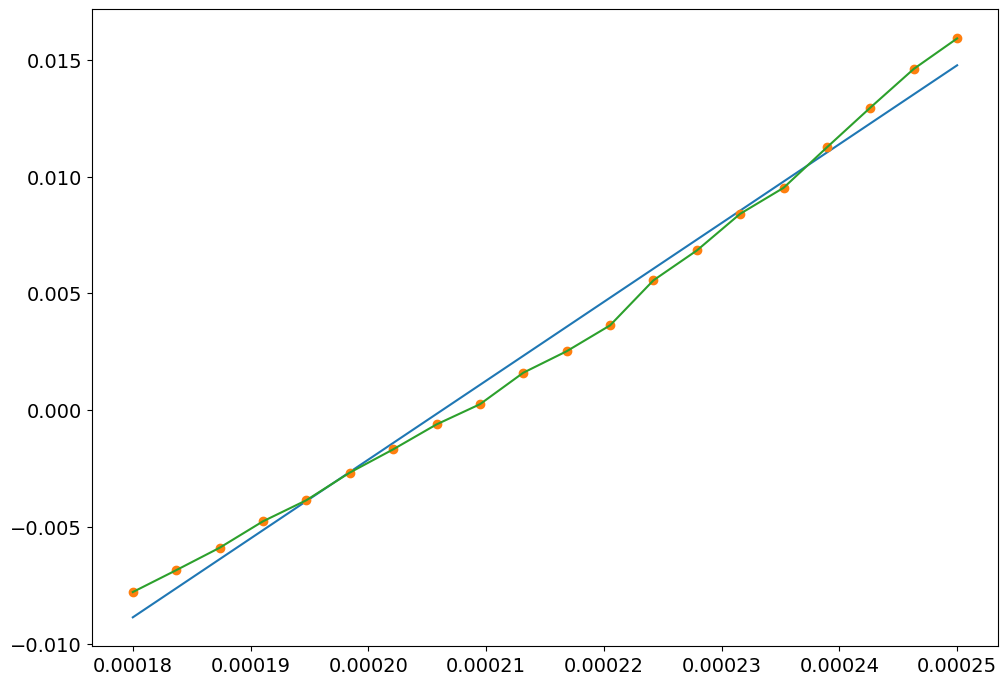

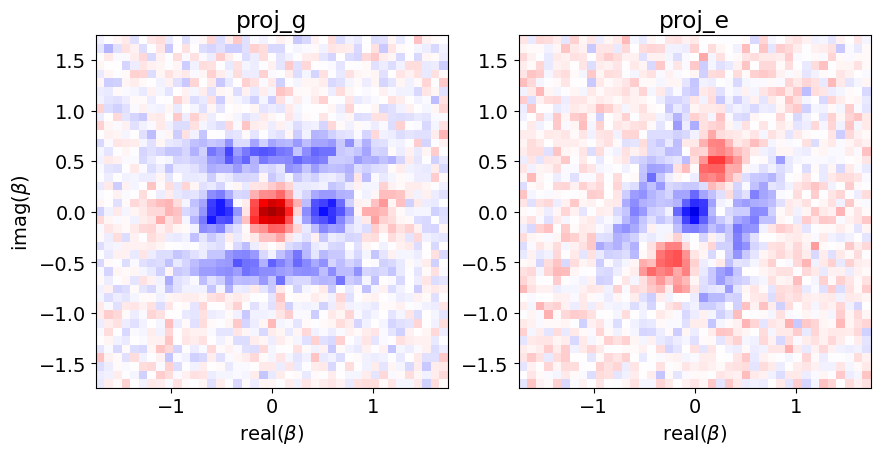

In [29]:
vac_norm = 0.883
filename = 'panther_sq_vcat_7db_oddcat.h5' 

d = ["C:/Users/jonat/Desktop/Coding/tcsim/data_analysis/data/all_data_new/fig4/7db_oddcat_1/", "C:/Users/jonat/Desktop/Coding/tcsim/data_analysis/data/all_data_new/fig4/7db_oddcat_20/", "C:/Users/jonat/Desktop/Coding/tcsim/data_analysis/data/all_data_new/fig4/7db_oddcat_50/", "C:/Users/jonat/Desktop/Coding/tcsim/data_analysis/data/all_data_new/fig4/7db_oddcat_100/"]

thresholds = np.linspace(1.8e-4,2.5e-4, 20)
floor_values = []
for threshold in thresholds:
    proj_g, x, y= load_data_single(d[3], filename ,thresh=threshold, plot=False)
    floor_values.append(proj_g[0:5,:].mean())
    

popt, pcov = curve_fit(line, thresholds, floor_values, p0= [0,0])
print(popt)
plt.plot(thresholds,line(np.array(thresholds),*popt))
plt.plot(thresholds,floor_values, 'o')
thresh = (-popt[1]/popt[0])
    
plt.plot(thresholds,floor_values)
print(thresh)

proj_g, x,y = load_data_single(d[0], filename, thresh, 1.2, 1)
proj_g_norm = proj_g/0.884

In [141]:
N = 19
a = qt.tensor(Iq, qt.destroy(N))
Ic = qt.qeye(N)
Iq = qt.qeye(2)

# Projectors
proj_g = qt.tensor(qt.fock(2,0)*qt.fock(2,0).dag(), Ic)
proj_e = qt.tensor(qt.fock(2,1)*qt.fock(2,1).dag(), Ic)

# Qubit Operators
sx = qt.tensor(qt.sigmax(), Ic)
sy = qt.tensor(qt.sigmay(), Ic)
sz = qt.tensor(qt.sigmaz(), Ic)
vac = qt.tensor(qt.fock(2,0),qt.fock(N,0))

def Rx(theta):
    return qt.tensor(rx(theta), Ic)
def Ry(theta):
    return qt.tensor(ry(theta), Ic)
def Rz(theta):
    return qt.tensor(rz(theta), Ic)

def U_ideal_operator(u_k):
    P = (1j*(a.dag()-a))/2
    Uk = (1j*u_k*P*sx).expm()
    return Uk

def V_ideal_operator(v_k):
    X = (a.dag()+a)/2
    Vk = (1j*v_k*X*sy).expm()
    return Vk

def squeezingStateThreeStep(uvs):
    u_1 = uvs[0]
    v_1 = uvs[1]
    u_2 = uvs[2]
    v_2 = uvs[3]
    u_3 = uvs[4]
    v_3 = uvs[5]

    psi1 = V_ideal_operator(v_1)*U_ideal_operator(u_1)*vac
    psi2 = V_ideal_operator(v_2)*U_ideal_operator(u_2)*psi1
    psi3 = V_ideal_operator(v_3)*U_ideal_operator(u_3)*psi2
 
    return psi3

# create theoretical states

def sq7_cat(N,alpha):
    uv = [-0.83900019,  0.56644014,  1.2973754 , -0.59798946, -1.26378237,
        0.38608659]
    sq7_tensor = squeezingStateThreeStep(uv)
    sq7 = ptrace(sq7_tensor,1).unit()
    cat = ((displace(N,1j*alpha) - displace(N, -1j*alpha))*sq7*((displace(N,1j*alpha) - displace(N, -1j*alpha))).dag()).unit()
    return cat

In [143]:
rho = reconstruct_dm(proj_g_norm, x, N)

alphas = np.linspace(0.7,0.9,10)
for alpha in alphas:
    cat = sq7_cat(N, alpha)
    overlap = expect(rho, cat)
    print(np.round(alpha,2), overlap)
    

100%|██████████| 1681/1681 [00:19<00:00, 85.15it/s] 
606841it [00:09, 64544.35it/s]


0.7 0.4097737817029397
0.72 0.4163763553397708
0.74 0.42130338335510975
0.77 0.42456989138083584
0.79 0.4262340520738805
0.81 0.4263857993119129
0.83 0.42513485180910804
0.86 0.4225994631844106
0.88 0.4188970075345699
0.9 0.41413706706758874


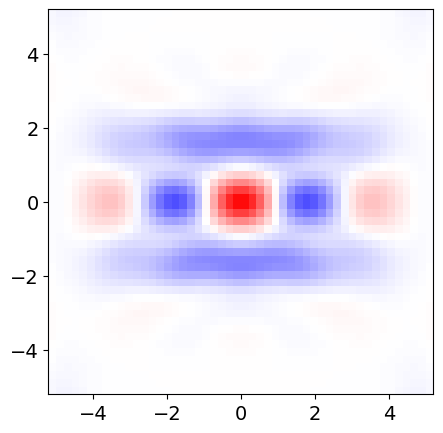

In [122]:
plot_char(tensor(fock(2,0)*fock(2,0).dag(),cat7), max_alpha = 5.1)

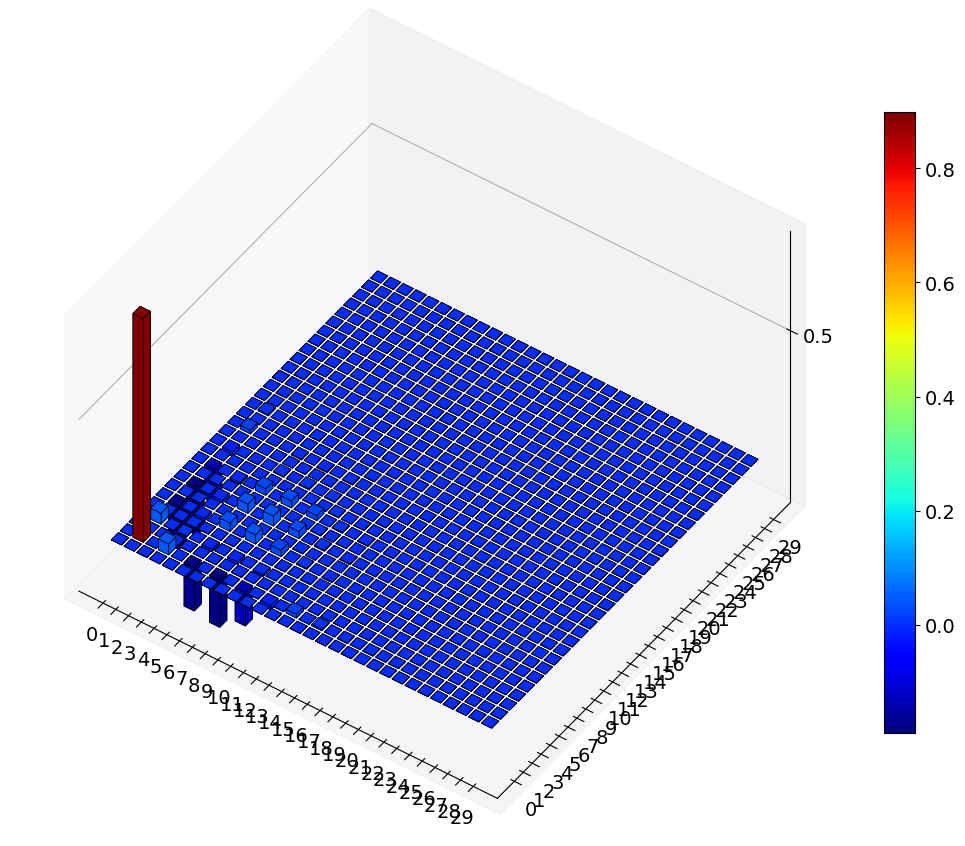

In [124]:


fig, ax = qt.matrix_histogram(cat7)
ax.view_init(azim=-55, elev=45)
plt.show()

## Bootstrap!